**Image Processing Laboratory (045108) - Meeting 4/4**  

Signal and Image Processing Lab (SIPL) & Vision and Image Sciences Lab (VISL)  
The Andrew and Erna Viterbi Faculty of Electrical and Computer Engineering    
Technion - Israel Institute of Technology

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, feature, filters, measure, morphology, io, transform, util
from lab_code import flir_image_extractor
from lab_code.apply_noise import apply_noise


# Helper Functions

In [2]:
def visual_prep(filename, convert_to_grayscale=True, target_width = 1600):
    """
    Prepare an image for the lab: read it, optionally convert to grayscale, and
    downscale it to a target width.

    Args:
        filename (str): Path to the image file.
        convert_to_grayscale (bool, optional): Whether to convert to grayscale.
            Default: True.
        target_width (int, optional): Maximum width in pixels. Images wider than this
            are downscaled with aspect ratio preserved; narrower images keep their
            original size. Default: 1600.

    Returns:
        numpy.ndarray: The processed image as uint8.
    """

    image = io.imread(filename)
    if image.ndim == 3 and image.shape[2] == 4:
        image = color.rgba2rgb(image)
    if convert_to_grayscale and image.ndim == 3:
        image = color.rgb2gray(image)

    height, width = image.shape[:2]

    # Resize to target_width while preserving aspect ratio
    if width > target_width:
        scale = target_width / width
        new_height = int(round (height * scale))
        image = transform.resize(image, (new_height, target_width), anti_aliasing=True)

    image = util.img_as_ubyte(image)

    return image


def thermal_prep(filename):
    """
    Prepare a FLIR thermal image for the lab by reading it.

    Args:
        filename (str): Path to the FLIR thermal image file.

    Returns:
        numpy.ndarray: The prepared thermal image as a 2D float array.
    """

    image_extractor = flir_image_extractor.FlirImageExtractor()
    image_extractor.process_image(filename)
    thermal = image_extractor.extract_thermal_image()

    return thermal


def thermal_prep_uint8(filename, vmin=None, vmax=None, clip_percentiles=(2, 98)):
    """
    Prepare a FLIR thermal image for the lab by reading it and mapping its dynamic range
    to uint8.

    Args:
        filename (str): Path to the FLIR thermal image file.
        vmin/vmax (float, optional): Lower/upper raw thermal values to map to 0/255. If
            either is 'None', it is inferred from the specified 'clip_percentiles'.
            Default: None.
        clip_percentiles ((float, float), optional): Percentiles (low, high) in [0, 100]
            used to infer 'vmin'/'vmax' when not provided. Default: (2, 98).

    Returns:
        numpy.ndarray: The thermal image mapped to uint8.
    """

    thermal = thermal_prep(filename).astype(np.float32)

    # Auto-select vmin/vmax if not provided
    if vmin is None or vmax is None:
        lo, hi = np.percentile(thermal, clip_percentiles)
        vmin = lo if vmin is None else vmin
        vmax = hi if vmax is None else vmax

    scaled = (thermal - vmin) * (255.0 / max(1e-6, (vmax - vmin)))
    return np.clip(scaled, 0, 255).astype(np.uint8)


def detect_and_visualize_bounding_boxes(binary_mask, image, denoising_level=10, max_boxes=5):
    """
    Detects connected components in a binary mask and visualize them with bounding boxes
    on the original image.

    Args:
    - binary_mask (np.ndarray): Binary mask where region pixels are represented by
        non-zero.
    - image (np.ndarray): Original image (grayscale or RGB) to overlay bounding boxes on.
    - denoising_level (int, optional): Amount of denoising to perform on the binary
        mask. A larger value applies stronger denoisng by removing larger objects.
        Default is 10.
    - max_boxes (int, optiona;): Maximum number of bounding boxes to detect, sorted by
        area. Default is 5.

    Returns:
    - List of tuples: Each tuple contains the coordinates of the bounding box in the format
        ((min_col, min_row), (max_col, max_row)).
    """

    # Apply morphological operations to clean the image
    selem = morphology.footprint_rectangle((denoising_level, denoising_level))
    cleaned_mask = morphology.opening(binary_mask, selem)

    # Label connected regions (blobs) in the binary mask
    labeled_regions = measure.label(cleaned_mask, return_num=False)

    # Loop through each labeled region to find bounding boxes
    bounding_boxes = []
    for region in measure.regionprops(labeled_regions):
        min_row, min_col, max_row, max_col = region.bbox
        bounding_boxes.append(((min_col, min_row), (max_col, max_row)))

    # Sort the rectangles by area in descending order and keep only the largest
    bounding_boxes = sorted(bounding_boxes, key=lambda x: (x[1][0] - x[0][0]) * (x[1][1] - x[0][1]), reverse=True)[:max_boxes]

    # Visualize the result
    fig, ax = plt.subplots(figsize=(10, 4))

    if image.ndim == 2:  # grayscale image
        ax.imshow(image, cmap='gray')
    else:                      # RGB image
        ax.imshow(image)

    for rect in bounding_boxes:
        (min_col, min_row), (max_col, max_row) = rect
        rect_patch = plt.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                                   edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect_patch)

    plt.title(f'Original Image with Detected Bounding Boxes')
    plt.tight_layout()
    plt.show()

    return bounding_boxes


def extract_image_patch(image, bounding_box):
    """
    Extracts a grayscale patch from an RGB image based on the given bounding box
    coordinates.

    Args:
    - image (np.ndarray): The original RGB image from which to extract the patch.
    - bounding_box (tuple): A tuple representing the bounding box in the format
        ((min_col, min_row), (max_col, max_row)).

    Returns:
    - nd.ndarray: A grayscale patch from the image corresponding to the bounding box.
    """

    # Convert the RGB image to grayscale
    grayscale_image = color.rgb2gray(image)

    # Extract the bounding box coordinates
    (min_col, min_row), (max_col, max_row) = bounding_box

    # Extract the grayscale patch from the bounding box
    grayscale_patch = grayscale_image[min_row:max_row, min_col:max_col]

    return grayscale_patch



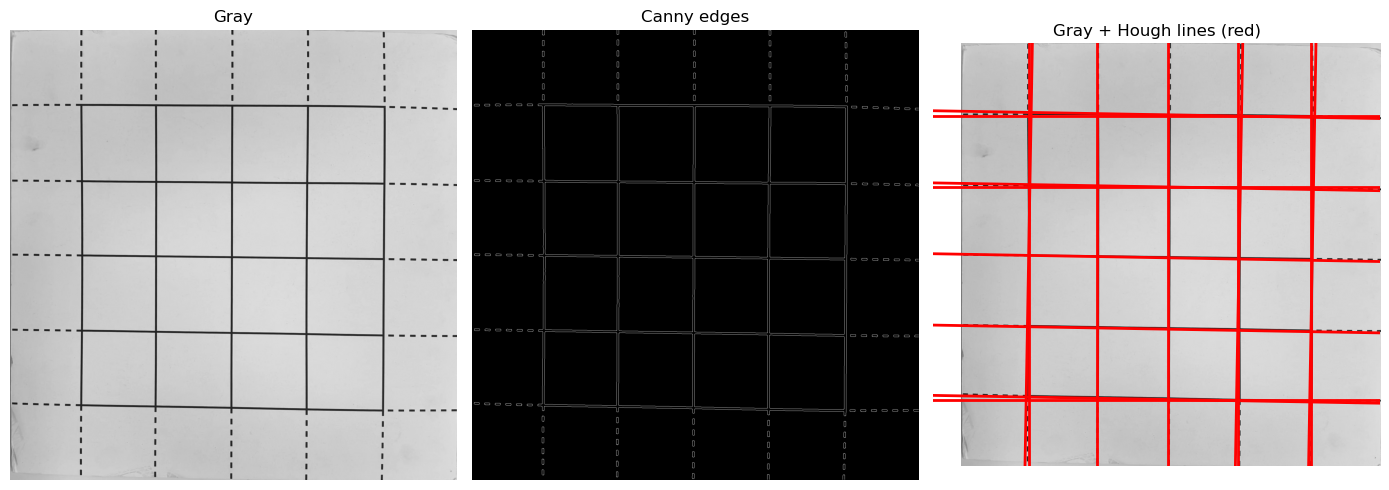

In [ ]:
# Question 1 

import numpy as np
import matplotlib.pyplot as plt
from skimage import color, exposure, feature, transform

# helper: convert to grayscale if image is RGB/RGBA
def _to_gray(img):
    if img.ndim == 3:                 # if the image is rgb it will have 3 dimensions (gray has 2) last cell is array RGB
        if img.shape[2] == 4:         # if the 3rd cell (color cell) is an array of 4 (= RedGreenBlueAlpha Alpha=brightness)
            img = color.rgba2rgb(img)
        return color.rgb2gray(img)
    return img

def show_gray_canny_and_hough_lines_labstyle(
    image_path,
    target_width=1600,
    canny_sigma=1.6,          
    low_pct=15, high_pct=85,  # percentiles for canny thresholds
    hough_peaks_threshold=0.25, # alpha * max(H) as in the notebook
    num_peaks=150             # max number of lines to draw
):
    """
    Show 3 panels: (1) Gray, (2) Canny edges, (3) Gray + Hough lines (red).
    Returns: (edges, strong_lines) with strong_lines = [((x0,y0), slope)].
    """

    # read & prepare image using the lab helper
    img  = visual_prep(image_path, convert_to_grayscale=False, target_width=target_width)
    gray = _to_gray(img)

    # Canny thresholds from percentiles 
    lo, hi = np.percentile(gray, [low_pct, high_pct]) 
    edges = feature.canny(gray, sigma=canny_sigma, low_threshold=lo, high_threshold=hi) #canny with sigma=1.6 for gaussian return binary image inot "edges" variable

    # Hough transform + pick strong peaks with a relative threshold
    H, angles, dists = transform.hough_line(edges) # inserting data with hough method to H, angles, dists
    peaks = transform.hough_line_peaks(            # using the data from hough to detect most pointers
        H, angles, dists,
        threshold=hough_peaks_threshold * np.max(H),
        num_peaks=num_peaks
    )

    # build strong lines list from raw and theta : x*cos(teta) + y*sin(teta) = ֿRaw
    strong_lines = []
    for _, angle, dist in zip(*peaks):
        x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])
        slope  = np.tan(angle + np.pi/2)
        strong_lines.append(((x0, y0), slope))

    # results 
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))

    # (1) Gray
    axes[0].imshow(gray, cmap='gray')
    axes[0].set_title('Gray'); axes[0].axis('off')

    # (2) Canny
    axes[1].imshow(edges, cmap='gray')
    axes[1].set_title('Canny edges'); axes[1].axis('off')

    # (3) Gray + Hough lines in red using axline (infinite line clipped by axes)
    axes[2].imshow(gray, cmap='gray')
    for (x0, y0), slope in strong_lines:
        axes[2].axline((x0, y0), slope=slope, color='red', linewidth=2)
    axes[2].set_title('Gray + Hough lines (red)'); axes[2].axis('off')

    plt.tight_layout(); plt.show()

    return edges, strong_lines

# ---- example call (replace path as needed) ----
_ = show_gray_canny_and_hough_lines_labstyle(
    'C:/Users/ompal/Desktop/meet4/meeting4/images/board.jpeg',
    target_width=1600,
    canny_sigma=1.6,
    low_pct=15, high_pct=85,
    hough_peaks_threshold=0.25,
    num_peaks=150
)

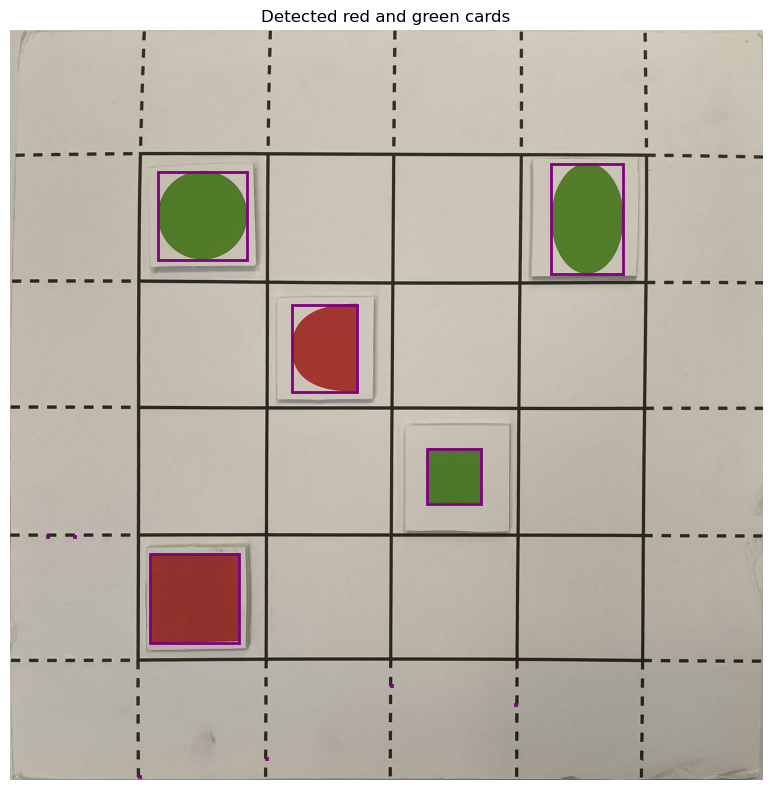

In [ ]:
# Question 2

import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, util

def segment_red_green_cards_rgb(
    image_path,
    r_thr=0.42, g_thr=0.42,            # red/green chroma thresolds
    diff_rg_red=0.12, diff_rb_red=0.12,# red must be > green & blue
    diff_gr_green=0.12, diff_gb_green=0.12,  # green must be > red & blue
    show=True
):
    # read RGB image (no grayscale), keep original size
    # use visual_prep but force no downscale by giving a huge width
    img = visual_prep(image_path, convert_to_grayscale=False).astype(np.float32)

    if img.max() > 1.1:  # if uint8 convert to [0,1]
        img = img / 255.0

    # split channels
    R, G, B = img[...,0], img[...,1], img[...,2]
    S = R + G + B + 1e-6          # sum (avoid devision by zero)
    r = R / S                     # red 
    g = G / S                     # green 

    # red mask: pick pixels where red is strong and much bigger than g and b
    red_mask   = (r > r_thr) & ((r - g) > diff_rg_red)   & ((r - (B/S)) > diff_rb_red)
    # green mask: pick pixels where green is strong and much bigger than r and b
    green_mask = (g > g_thr) & ((g - r) > diff_gr_green) & ((g - (B/S)) > diff_gb_green)

    # label connected components (no size/border/aspect filtering at all)
    def _boxes_from_mask(mask):
        labeled = measure.label(mask)
        rects = []
        for rgn in measure.regionprops(labeled):
            r0, c0, r1, c1 = rgn.bbox
            rects.append(((c0, r0), (c1, r1)))  # save bbox (x0,y0)-(x1,y1)
        return rects

    red_boxes   = _boxes_from_mask(red_mask)
    green_boxes = _boxes_from_mask(green_mask)

    # draw results purpple boxes
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(util.img_as_ubyte(img))
        for (c0, r0), (c1, r1) in red_boxes:
            ax.add_patch(plt.Rectangle((c0, r0), c1 - c0, r1 - r0, edgecolor='purple', facecolor='none', linewidth=2))
        for (c0, r0), (c1, r1) in green_boxes:
            ax.add_patch(plt.Rectangle((c0, r0), c1 - c0, r1 - r0, edgecolor='purple', facecolor='none', linewidth=2))
        ax.set_title('Detected red and green cards')
        ax.axis('off'); plt.tight_layout(); plt.show()

    return {"red": red_boxes, "green": green_boxes, "all": red_boxes + green_boxes}

# run example (no resize, no brightness term)
_ = segment_red_green_cards_rgb(
    image_path='C:/Users/ompal/Desktop/meet4/meeting4/images/board_with_cards.jpeg',
    r_thr=0.52, g_thr=0.42,
    diff_rg_red=0.35, diff_rb_red=0.35,
    diff_gr_green=0.10, diff_gb_green=0.10,
    show=True
)

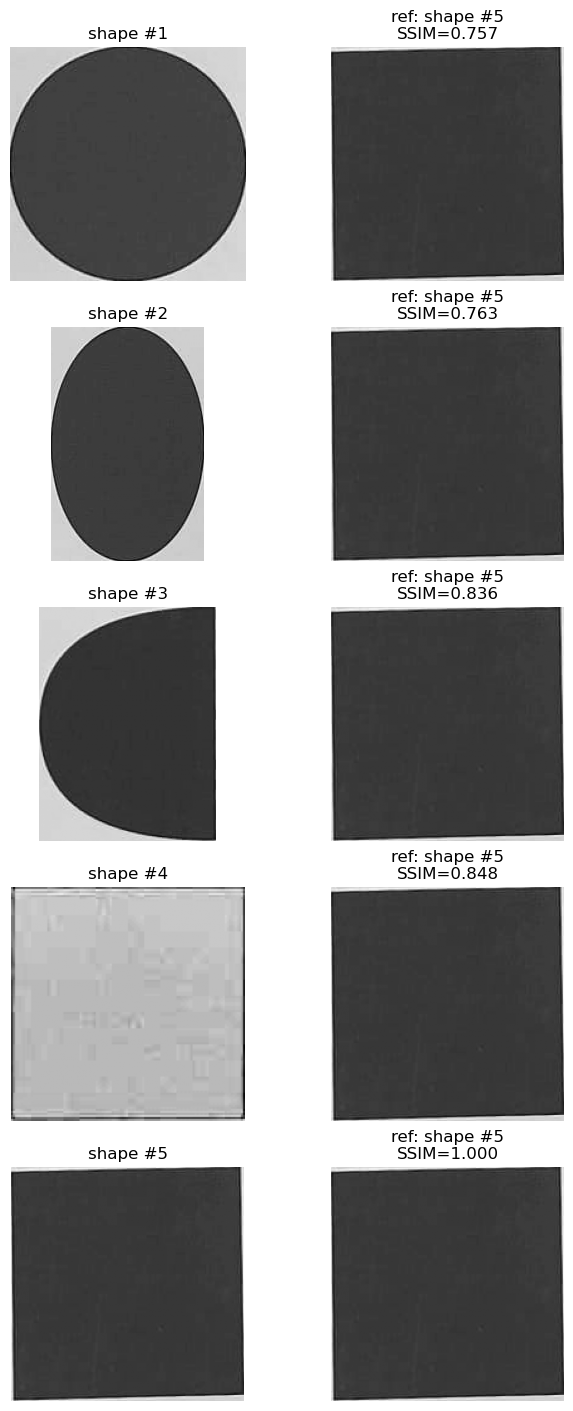

In [ ]:
# Question 4

import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage.metrics import structural_similarity as ssim

def _pad_center(img, H, W, fill_val=None):
    """Pad a grayscale image to size (H,W) and center it."""
    h, w = img.shape
    if fill_val is None:  # default fill value from border pixels
        border_vals = np.concatenate([img[0,:], img[-1,:], img[:,0], img[:,-1]])
        fill_val = np.median(border_vals)
    out = np.full((H, W), fill_val, dtype=img.dtype)
    r0 = (H - h) // 2
    c0 = (W - w) // 2
    out[r0:r0+h, c0:c0+w] = img
    return out

def compare_all_to_patch_ssim_noresize(
        patches,
        ref_index=3,              # 0-based (3 == shape #4)
        show_pairs=True,
        display_mode='pad_ref_to_candidate'   # 'native' | 'crop' | 'pad_ref_to_candidate'
    ):
    """
    Compare all patches to a reference without resizing.
    - SSIM: computed on overlap only.
    - display_mode='pad_ref_to_candidate':
        Left = candidate (original size).
        Right = reference padded to candidate size (no resize).
        Both fill the subplot, aspect ratio is kept.
    """
    assert 0 <= ref_index < len(patches)
    grays = [color.rgb2gray(p.astype(np.float32)) for p in patches]
    ref_gray = grays[ref_index]
    Href, Wref = ref_gray.shape

    results = []
    for i, cand_gray in enumerate(grays, start=1):
        Hc, Wc = cand_gray.shape
        H, W = min(Hc, Href), min(Wc, Wref)
        ssim_val = ssim(cand_gray[:H, :W], ref_gray[:H, :W], data_range=1.0)
        results.append((i, ssim_val, cand_gray))

    if show_pairs:
        n = len(patches)
        fig, axes = plt.subplots(n, 2, figsize=(6.4, 2.8*n), constrained_layout=True)

        for row, (idx, ssim_val, cand_gray) in enumerate(results):
            if display_mode == 'native':
                left_img  = cand_gray
                right_img = ref_gray
            elif display_mode == 'crop':
                H = min(cand_gray.shape[0], Href); W = min(cand_gray.shape[1], Wref)
                left_img  = cand_gray[:H, :W]
                right_img = ref_gray[:H, :W]
            else:  # 'pad_ref_to_candidate'
                Hc, Wc = cand_gray.shape
                left_img  = cand_gray
                right_img = _pad_center(ref_gray, Hc, Wc)   # pad ref to candidate size

            axes[row, 0].imshow(left_img, cmap='gray')
            axes[row, 0].set_title(f"shape #{idx}")
            axes[row, 0].axis('off')

            axes[row, 1].imshow(right_img, cmap='gray')
            axes[row, 1].set_title(f"ref: shape #{ref_index+1}\nSSIM={ssim_val:.3f}")
            axes[row, 1].axis('off')

        plt.show()

    return results

# compute metrics vs. candidate shape 
metrics_vs_4 = compare_all_to_patch_ssim_noresize(
    patches,
    ref_index=4,          # choose any index between 0-4 to select the reference shape
    show_pairs=True,
    display_mode='native' 

C:\Users\ompal\AppData\Local\Temp\ipykernel_81832\1777817154.py:71: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  med = filters.median(util.img_as_ubyte(noisy[..., ch]), morphology.square(median_ksize))


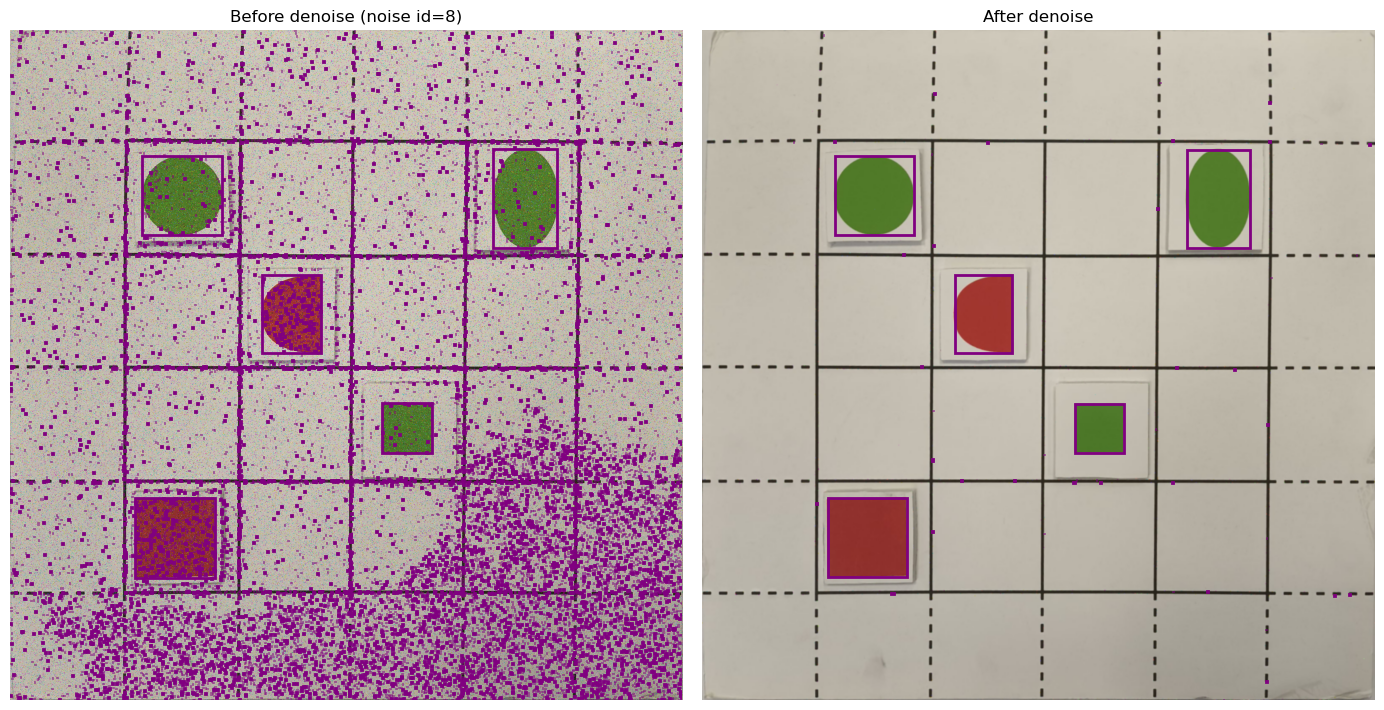

In [ ]:
# Question 5 
import numpy as np
import matplotlib.pyplot as plt
from skimage import util, measure, filters, morphology, color

# Core detection from section 2
def _segment_red_green_cards_from_img(
    img,
    r_thr=0.42, g_thr=0.42,
    diff_rg_red=0.12, diff_rb_red=0.12,
    diff_gr_green=0.12, diff_gb_green=0.12,
    show=True, title="Detected red & green cards"
):
    if img.max() > 1.1:
        img = img.astype(np.float32) / 255.0
    R, G, B = img[...,0], img[...,1], img[...,2]
    S = R + G + B + 1e-6
    r = R / S
    g = G / S

    # Masks
    red_mask   = (r > r_thr) & ((r - g) > diff_rg_red)   & ((r - (B/S)) > diff_rb_red)
    green_mask = (g > g_thr) & ((g - r) > diff_gr_green) & ((g - (B/S)) > diff_gb_green)

    def _boxes_from_mask(mask):
        labeled = measure.label(mask)
        rects = []
        for rgn in measure.regionprops(labeled):
            r0, c0, r1, c1 = rgn.bbox
            rects.append(((c0, r0), (c1, r1)))
        return rects

    red_boxes   = _boxes_from_mask(red_mask)
    green_boxes = _boxes_from_mask(green_mask)
    all_boxes   = red_boxes + green_boxes

    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.imshow(util.img_as_ubyte(img))
        for (c0, r0), (c1, r1) in all_boxes:
            ax.add_patch(plt.Rectangle((c0, r0), c1 - c0, r1 - r0,
                                       edgecolor='purple', facecolor='none', linewidth=2))
        ax.set_title(title)
        ax.axis("off")
        plt.tight_layout(); plt.show()

    return {"red": red_boxes, "green": green_boxes, "all": all_boxes}

# noisy + denoise + detect + side-by-side visualization 
def segment_red_green_cards_rgb_denoised(
    image_path,
    noise_id=8,
    r_thr=0.42, g_thr=0.42,
    diff_rg_red=0.12, diff_rb_red=0.12,
    diff_gr_green=0.12, diff_gb_green=0.12,
    median_ksize=3, gauss_sigma=1.0,
    show=True
):
    # load RGB (no grayscale), keep original size
    img = visual_prep(image_path, convert_to_grayscale=False).astype(np.float32)
    if img.max() > 1.1:
        img = img / 255.0

    # add lab noise
    noisy = apply_noise(img, noise_id)

    # ---- denoise per channel ----
    den_channels = []
    for ch in range(3):
        med = filters.median(util.img_as_ubyte(noisy[..., ch]), morphology.square(median_ksize))
        med = util.img_as_float32(med)
        gauss = filters.gaussian(med, sigma=gauss_sigma, preserve_range=True)
        den_channels.append(gauss)
    den = np.stack(den_channels, axis=-1)

    # run detector on both versions
    out_noisy = _segment_red_green_cards_from_img(
        noisy,
        r_thr=r_thr, g_thr=g_thr,
        diff_rg_red=diff_rg_red, diff_rb_red=diff_rb_red,
        diff_gr_green=diff_gr_green, diff_gb_green=diff_gb_green,
        show=False
    )
    out_denoised = _segment_red_green_cards_from_img(
        den,
        r_thr=r_thr, g_thr=g_thr,
        diff_rg_red=diff_rg_red, diff_rb_red=diff_rb_red,
        diff_gr_green=diff_gr_green, diff_gb_green=diff_gb_green,
        show=False
    )

    # side-by-side BEFORE (noisy) vs AFTER (denoised)
    if show:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # BEFORE: noisy
        axes[0].imshow(util.img_as_ubyte(noisy))
        for (c0, r0), (c1, r1) in out_noisy["all"]:
            axes[0].add_patch(plt.Rectangle((c0, r0), c1 - c0, r1 - r0,
                                            edgecolor='purple', facecolor='none', linewidth=2))
        axes[0].set_title(f"Before denoise (noise id={noise_id})")
        axes[0].axis('off')

        # AFTER: denoised
        axes[1].imshow(util.img_as_ubyte(den))
        for (c0, r0), (c1, r1) in out_denoised["all"]:
            axes[1].add_patch(plt.Rectangle((c0, r0), c1 - c0, r1 - r0,
                                            edgecolor='purple', facecolor='none', linewidth=2))
        axes[1].set_title("After denoise")
        axes[1].axis('off')

        plt.tight_layout(); plt.show()

    # return both results for further use
    return {
        "noisy_boxes": out_noisy["all"],
        "denoised_boxes": out_denoised["all"],
        "noisy_image": noisy,
        "denoised_image": den
    }

# --- Example run (check digit = 8) ---
_ = segment_red_green_cards_rgb_denoised(
    image_path='C:/Users/ompal/Desktop/meet4/meeting4/images/board_with_cards.jpeg',
    noise_id=8,
    r_thr=0.52, g_thr=0.42,
    diff_rg_red=0.35, diff_rb_red=0.35,
    diff_gr_green=0.10, diff_gb_green=0.10,
    median_ksize=3, gauss_sigma=1.0,
    show=True
)